In [1]:
cd /mmfs1/data/aglinska/BC-fMRI-AE/

/mmfs1/data/aglinska/BC-fMRI-AE


In [2]:
%time
import pandas as pd
import ants
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.34 µs


In [3]:
df = pd.read_csv('./Data/ABIDE_df.csv')
df = df.iloc[~pd.isna(df['bids_folder'].values)]

In [4]:
template_anat = ants.image_read('./Data/YeoAtlas/Atlas_brain_2mm.nii')
template_rois = ants.image_read('./Data/YeoAtlas/Atlas_parc-7n_2mm.nii')

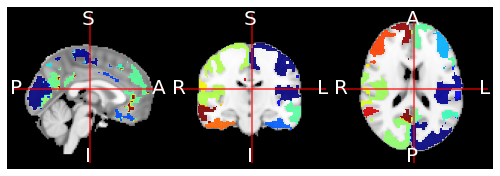

In [5]:
template_anat.plot_ortho(template_rois,flat=True)

In [6]:
def get_epi(s):
    #s = 80
    sub = df['bids_folder'].values[s]
    epi = ants.image_read(f'../data/ABIDE/Derivatives/cpac_nofilt_global/{sub}/ses-1/func/{sub}_ses-1_mean.nii.gz')
    return epi

In [7]:
n = len(df)
epis = np.array([get_epi(s).numpy() for s in tqdm(range(n))])

100%|██████████| 1102/1102 [00:47<00:00, 23.40it/s]


<bound method ANTsImage.new_image_like of ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (61, 73, 61)
	 Spacing    : (3.0, 3.0, 3.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
>

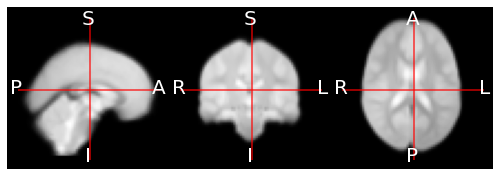

In [11]:
mepi = get_epi(0).new_image_like(epis.mean(axis=0))
mepi.plot_ortho(flat=True)
mepi.to_filename('./Data/YeoAtlas/ABIDE_mepi.nii.gz')

In [12]:
# mepi = epi.new_image_like(epis.mean(axis=0))
# mepi.plot_ortho(flat=True)

In [13]:
tx = ants.registration(
    fixed=mepi,
    moving=template_anat,
    type_of_transform='SyN',
    initial_transform=None)

In [14]:
epi_rois = ants.apply_transforms(
    fixed=mepi,
    moving=template_rois,
    transformlist=tx['fwdtransforms'],
    interpolator='genericLabel')

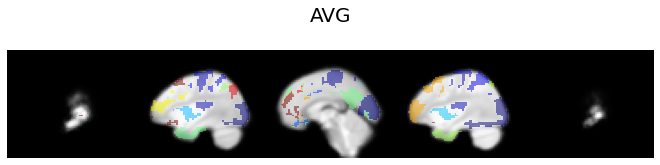

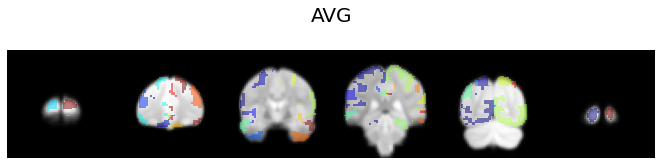

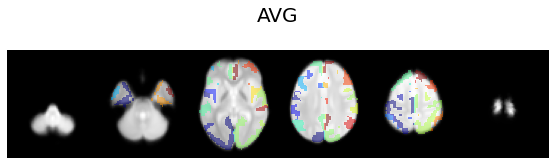

In [15]:
mepi.plot(epi_rois,title='AVG',overlay_alpha=.5,nslices=5,axis=0)
mepi.plot(epi_rois,title='AVG',overlay_alpha=.5,nslices=6,axis=1)
mepi.plot(epi_rois,title='AVG',overlay_alpha=.5,nslices=6,axis=2)

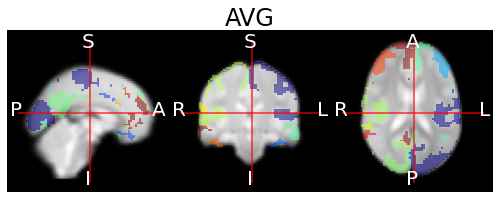

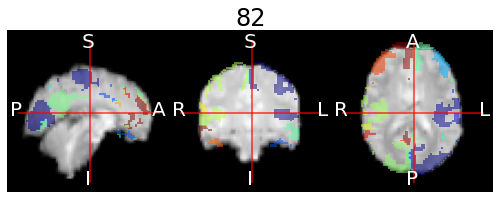

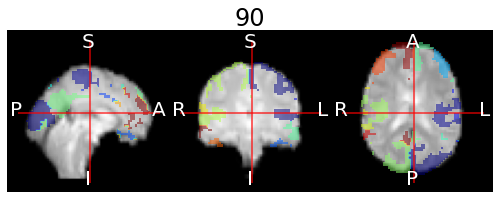

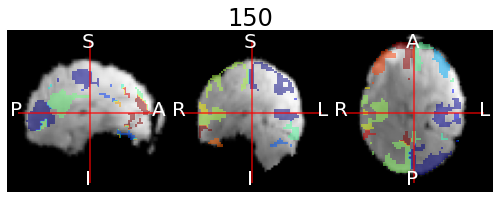

In [16]:
mepi.plot_ortho(epi_rois,flat=True,title='AVG',overlay_alpha=.5)
for i in range(3):
    ri = np.random.randint(low=0,high=1000,size=1)[0]
    this_epi = get_epi(ri)
    this_epi.plot_ortho(epi_rois,flat=True,title=ri,overlay_alpha=.5)   

In [18]:
epi_rois.to_filename('./Data/YeoAtlas/epi_rois.nii.gz')